# Introduction
This model is a recommender system for Steam games. It is based on the dataset from Steam, which is a digital distribution platform for video games. The dataset contains 316 games and 21 million users. The recommender system is based on collaborative filtering and content based model. The system integrates the recommender module and a user interaction module.

**Pipeline For Content-based model:**

1. Data preprocessing, Analysis and Visualization
2. Extracting features from the game dataset, build feature vectors for games. The item vector is a hierarchical structure. First, for the description, use text vectorization technology (such as TF-IDF or Word2Vec) to process the description text of the game to generate a dense numerical vector for each game. For Tags, we still use TF-IDF. But since the game tag describes the game more significantly, we manually increase the TF-IDF weight of the tag.

__Inporting Libraries__

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

__Data Preprocessing__

In [5]:
file_path_reviews = "new_steam_reviews.csv"
file_path_desc = "new_desc.csv"
file_path_tags = "new_tags.csv"

df_reviews = pd.read_csv(file_path_reviews)
df_count = df_reviews['author.steamid'].value_counts().to_frame().reset_index().rename(columns={'author.steamid': 'index'})
df_reviews = df_reviews.loc[df_reviews['author.steamid'].isin(df_count.query("count >= 10")['index'].values), :]
df_desc = pd.read_csv(file_path_desc)
df_tags = pd.read_csv(file_path_tags)

In [6]:
print(df_desc.head())
print(df_tags.head())
print(df_reviews['author.steamid'].head())

     id                                  short_description
0    70  This mod is to run Half-Life 2: Update (itself...
1   240  Counter-Strike: Source blends Counter-Strike's...
2   420  The second episodic sequel to one of the most ...
3   620  Get Portal™2 In Motion™, Adventure, Puzzle, Sh...
4  2870  In the distant future, the X universe faces a ...
   app_id                                               tags
0      70                                        ['Shooter']
1     240                                        ['Shooter']
2     420                             ['Shooter', ' Puzzle']
3     620               ['Shooter', ' Puzzle', ' Adventure']
4    2870  ['Shooter', ' Real Time Strategy (RTS)', ' Sim...
10    76561198184596858
30    76561198063207357
39    76561198177937343
61    76561198346767187
86    76561198938824713
Name: author.steamid, dtype: int64


__Clean the data__

In [7]:
import ast
import re
def tags_preprocess(tag):
    tag = ast.literal_eval(tag)
    tag = [x.lower() for x in tag]
    tag = [x.replace(' ', '_') for x in tag]
    tag = [x.replace('-', '_') for x in tag]
    tag = ' '.join(tag)
    return tag
def desc_preprocess(desc):
    desc = '' if pd.isna(desc) else str(desc)
    desc = desc.lower()
    desc = re.sub(r'[^\w\s]', '', desc)  # Remove punctuation
    words = desc.split()  # Tokenize by splitting on whitespace
    return ' '.join(words)

In [8]:
# df_desc = df_desc.dropna(subset=['short_description'])
df_tags['tags'] = df_tags['tags'].apply(lambda x: tags_preprocess(x))
df_desc['short_description'] = df_desc['short_description'].apply(desc_preprocess)

__Extracting Features from the description dataset and the tags dataset__

In [45]:
import numpy as np

def data_split(df, train):
    shuffled_indices = np.random.permutation(df.index)

    if train < 1:
        train_set_size = int(len(df) * train)
    else:
        train_set_size = train

    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]

    train_set = df.loc[train_indices]
    test_set = df.loc[test_indices]

    return train_set, test_set


df_tags_train, df_tags_test = data_split(df_tags, 200)
df_desc_train, df_desc_test = data_split(df_desc, 200)
df_games= df_reviews.drop_duplicates(subset='app_id')
df_games_train, df_games_test = data_split(df_games, 200)


In [ ]:
import ast
tfidf_vectorizer_desc = TfidfVectorizer(stop_words='english')
tfidf_matrix_desc = tfidf_vectorizer_desc.fit_transform(df_desc['short_description'].tolist())
print(tfidf_matrix_desc)

Create user class. The user class takes user model as input. A user could be an existed user in our reviews data set either a new user, needing cold start which will be implemented later.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import pandas as pd


class User_CB:
    def __init__(self, user_mod, user_id=None):
        self.user_mod = user_mod
        self.user_id = user_id
        self.profile = []  # This array contains game ids.
        self.feature_arr = None  # Feature array (TF-IDF) depends on the profile array.
        self.recommendations = []
        self.liked_tags = Counter()
        self.limit = 100
        self.total_sum = 0

    def hot_start(self):
        df_user_reviews = df_reviews[(df_reviews["author.steamid"] == self.user_id)]
        for app_id in df_user_reviews["app_id"].values:
            self.like_game(app_id)

    def hot_start_evaluation(self):
        df_user_reviews = df_reviews[(df_reviews["author.steamid"] == self.user_id)]
        for app_id in df_user_reviews[
            df_user_reviews["app_id"].isin(df_tags_train["app_id"])
        ]["app_id"].values:
            self.like_game(app_id)

    def cold_start(self, liked_games):
        for id in liked_games:
            self.like_game(id)

    def update_profile(self, app_id):
        self.profile.append(app_id)
        # Get tags for the new game and update tag counts
        new_game_tags = df_tags[df_tags["app_id"] == app_id]["tags"].iloc[0].split()
        self.liked_tags.update(new_game_tags)
        self.generate_new_profile_vector()

    def generate_new_profile_vector(self):
        desc = df_desc.loc[df_desc["id"].isin(self.profile)]
        self.feature_arr = tfidf_vectorizer_desc.transform(desc["short_description"])

    def like_game(self, app_id):
        # if not app_id in self.profile:
        self.update_profile(app_id)

    def run_model_evaluation(self):
        cosine_similarities = cosine_similarity(self.feature_arr, tfidf_matrix_desc)
        adjusted_similarity_scores = []

        for game_idx, game_id in enumerate(df_tags_test["app_id"]):
            # if game_id not in self.profile:  # Skip games already liked
            custom_weight = self.calculate_custom_weight(game_id)
            adjusted_score = (cosine_similarities[0][game_idx] + 1) * custom_weight
            adjusted_similarity_scores.append((game_id, adjusted_score))

        adjusted_similarity_scores = sorted(
            adjusted_similarity_scores, key=lambda x: x[1], reverse=True
        )
        self.recommendations = [v for v, _ in adjusted_similarity_scores]
        return self.recommendations

    def run_model(self):
        cosine_similarities = cosine_similarity(self.feature_arr, tfidf_matrix_desc)
        adjusted_similarity_scores = []

        for game_idx, game_id in enumerate(df_desc_test["id"]):
            # if game_id not in self.profile:  # Skip games already liked
            custom_weight = self.calculate_custom_weight(game_id)
            adjusted_score = (cosine_similarities[0][game_idx] + 1) * custom_weight
            adjusted_similarity_scores.append((game_id, adjusted_score))

        adjusted_similarity_scores = sorted(
            adjusted_similarity_scores, key=lambda x: x[1], reverse=True
        )
        self.recommendations = [v for v, _ in adjusted_similarity_scores]
        return self.recommendations

    def calculate_custom_weight(self, game_id):
        game_tags_list = df_tags[df_tags["app_id"] == game_id]["tags"].iloc[0].split()
        weight_sum = 0
        total_sum = sum(dict(self.liked_tags).values())
        for tag in game_tags_list:
            if tag in dict(self.liked_tags):
                weight_sum += self.liked_tags[tag]
        return (weight_sum / total_sum) if total_sum > 0 else 0

The core idea of collaborative filtering recommendation system is to construct the user-items matrix through the user's comments on the game, calculate the similarity between users to predict the user's rating of the game, and introduce the weight to ensure the credibility of similar users

**Pipeline For CF model:**

1. Data sampling
2. Construct the user-item matrix
3. Construct the similarity function
4. Construct the rating prediction function
5. Implement a complete recommendation process





1. Data sampling

The original dataset presents a formidable challenge due to its overwhelming number of users, which poses a significant hurdle in constructing the User-Item matrix without overtaxing the available RAM. To tackle this issue effectively, the implementation of a thoughtful data sampling strategy becomes imperative. Our primary goal is to strategically curtail the user count, thereby enhancing the efficiency of the data processing pipeline.

Upon a detailed exploration of the dataset, a notable observation emerged: approximately 90% of the 12,000,000 users contributed more than 10 comments. Leveraging this insight, we refined our selection criteria, ultimately narrowing down the user pool to approximately 120,000 active users. This deliberate curation ensures that our subsequent analyses are not only more resource-efficient but also tailored to the subset of users who exhibit significant engagement, enhancing the relevance and depth of our findings.

2. Construct the user-item matrix

The construction of the user-item matrix was based on sampled dataset in the last step, comprising 120,000 distinct users and 315 unique games. Despite our efforts to filter out inactive users, the resulting matrix remains highly sparse.


3. Construct the similarity function

In our initial approach to the similarity function, we employed cosine similarity, a widely discussed method covered in our lectures, to compute the similarity between users. However, given that our user-items matrix comprises **120,000** users and **315** games, with many users reviewing only approximate 15 games, the 0-1 matrix is highly sparse. Cosine similarity proved ineffective for dealing with vectors that contain numerous empty values.

To address this challenge, we explored alternative similarity metrics, including Pearson Correlation Coefficient, Spearman's Rank Correlation Coefficient, and Kendall's Tau. Despite these efforts, we encountered less than perfect results. Ultimately, we opted to enhance the dataset by smoothing it, replacing 0s with 1s and empty values with 0s.

Our rationale for this transformation lies in our consideration that users who review a game, regardless of recommending it or not, exhibit an interest in the genre(s) of the game. Since users invest time playing a particular game, we assume they are inherently interested in its genre. Furthermore, if a user does not recommend a game, it suggests that the game itself lacks sufficient allure. Therefore, we chose to convert 0s to 1s, reflecting the user's implicit interest in the genre associated with the game.

4. Construct the rating prediction function

The rating prediction function was implemented with the equation taught through lecture.

$\hat{r}_{ui} = \frac{\sum_{j=1}^{M}  \text{cred}(v_j, i) \cdot \text{sim}(u, v_j) \cdot r_{v_j, i}}{\sum_{j=1}^{M} \text{cred}(v_j, i) \cdot \text{sim}(u, v_j)}$

$\text{sim}(u, v_j)$ refers to the similarity between $u$ and $v_j$

$\text{cred}(v_j, i)$ refers to how trustworthy the $v_j$'s rating on $i$. We introduce credibility to give each user a weight, so that the ratings are closer to those of the expert-like players. We measure the trustworthiness of a user by the following attributes in the dataset. 

After obtaining predicted ratings for all games, we will select the top N games to be recommended.

In [32]:
import bisect
import numpy as np


class User_CF:
    def __init__(self, user_id, evaluation=False):
        self.user_id = user_id
        self.recommendations = []

        if evaluation == True:
            self.evaluation()
        else:
            # Generate users-items matrix
            if user_id == 1:
                self.cold_start()
            else:
                self.u_a_df = df_reviews.pivot_table(
                    index="author.steamid", columns="app_id", values="recommended"
                )
                self.reviewed_games_ids = set(
                    self.u_a_df.loc[
                        user_id, self.u_a_df.columns[~self.u_a_df.loc[user_id].isna()]
                    ].index.tolist()
                )

            # dynamic update
            self.buffer = []

            # Intialize interest and rating matrix
            self.interest_matrix = self.u_a_df.replace(0, 1)
            self.interest_matrix = self.interest_matrix.fillna(0)
            self.rating_matrix = self.u_a_df.replace(0, -1)
            self.rating_matrix = self.rating_matrix.fillna(0)

    def cold_start(self):
        self.u_a_df = df_reviews.pivot_table(
            index="author.steamid", columns="app_id", values="recommended"
        )
        self.u_a_df.loc[1] = [np.nan] * len(self.u_a_df.columns)
        self.reviewed_games_ids = set()

    def similarity(self):
        interest_matrix = self.interest_matrix
        sim_matrix = self.cosine(interest_matrix)
        sorted_df = sim_matrix.sort_values(by="Similarity", axis=1, ascending=False)
        return sorted_df

    def cosine(self, matrix):
        uid = self.user_id
        target_user_ratings = matrix.loc[uid].to_frame().T
        similarity_scores = cosine_similarity(target_user_ratings, matrix)
        similarity_df = pd.DataFrame(
            similarity_scores, columns=matrix.index, index=["Similarity"]
        )
        return similarity_df

    def comment(self, aid):
        if aid in self.reviewed_games_ids:
            return
        self.buffer.append(aid)

    def update_profile(self):
        uid = self.user_id
        for i in self.buffer:
            self.reviewed_games_ids.add(i)
        for aid in self.buffer:
            self.interest_matrix.loc[uid][aid] = 1
            self.rating_matrix.loc[uid][aid] = 1
        self.buffer = []

    def run_model_cf(self):
        self.update_profile()

        # Predict rating by 5 similar users
        similar_users = self.similarity()
        ratings = []
        app_list = self.u_a_df.columns.tolist()
        for aid in app_list:
            if aid in self.reviewed_games_ids:
                continue
            count = 0
            up = 0
            down = 0
            user_list = similar_users.columns.tolist()[1:]
            for uid in user_list:
                if count == 5:
                    break

                rating = self.rating_matrix.loc[uid][aid]

                if rating == 0 or uid == self.user_id:
                    continue

                count += 1
                up += similar_users.iloc[0][uid] * rating * self.credibility(uid, aid)
                down += similar_users.iloc[0][uid] * self.credibility(uid, aid)

            final_rating = up / down
            ratings.append((final_rating, aid))

        ratings.sort()
        self.recommendations = [v for _, v in ratings]

        return self.recommendations

    def evaluation(self):
        user_id = self.user_id

        u_a_df = df_reviews.pivot_table(
            index="author.steamid", columns="app_id", values="recommended"
        )

        train_app_id = df_tags_train["app_id"].tolist()
        test_app_id = df_tags_test["app_id"].tolist()

        reviewed_games_ids = set(
            u_a_df.loc[
                user_id, u_a_df.columns[~u_a_df.loc[user_id].isna()]
            ].index.tolist()
        )
        reviewed_games_ids = set([i for i in reviewed_games_ids if i in train_app_id])

        interest = u_a_df[train_app_id]
        interest_matrix = interest.replace(0, 1)
        interest_matrix = interest_matrix.fillna(0)
        rating = u_a_df[test_app_id]
        rating_matrix = u_a_df.replace(0, -1)
        rating_matrix = rating_matrix.fillna(0)

        sim_matrix = self.cosine(interest_matrix)
        similar_users = sim_matrix.sort_values(by="Similarity", axis=1, ascending=False)

        ratings = []
        app_list = test_app_id
        for aid in app_list:
            count = 0
            up = 0
            down = 0
            user_list = similar_users.columns.tolist()[1:]
            for uid in user_list:
                if count == 5:
                    break

                rating = rating_matrix.loc[uid][aid]

                if rating == 0 or uid == user_id:
                    continue

                count += 1
                up += similar_users.iloc[0][uid] * rating * self.credibility(uid, aid)
                down += similar_users.iloc[0][uid] * self.credibility(uid, aid)

            final_rating = up / down
            ratings.append((final_rating, aid))

        ratings.sort()
        recommendations = [v for _, v in ratings]

        return recommendations

    def credibility(self, user_id, app_id):
        df = df_reviews

        def rank(sorted_list, value):
            # bisect_left function returns the index of the inserted value, which is the point that can be inserted while keeping the list sorted
            index = bisect.bisect_left(sorted_list, value)
            # Check if the index is in the range of the list and if the value of the list at the index is equal to the value we are looking for
            if index != len(sorted_list) and sorted_list[index] == value:
                return index + 1
            return -1

        def give_vote_score():
            vote_helpful = df.loc[
                (df["author.steamid"] == user_id) & (df["app_id"] == app_id),
                "votes_helpful",
            ].values[0]
            vote_funny = df.loc[
                (df["author.steamid"] == user_id) & (df["app_id"] == app_id),
                "votes_funny",
            ].values[0]
            if vote_helpful == 0:
                vote_score = 1
            elif 0 < vote_helpful < 10:
                vote_score = 2
            elif 10 <= vote_helpful < 50:
                vote_score = 3
            elif 50 <= vote_helpful < 100:
                vote_score = 4
            elif vote_helpful >= 100:
                vote_score = 5
            if vote_funny >= 10:
                vote_score += 1
            return vote_score

        def give_time_score():
            play_time = df.loc[
                (df["author.steamid"] == user_id) & (df["app_id"] == app_id),
                "author.playtime_at_review",
            ].values[0]
            if play_time < 100:
                time_score = 1
            elif 100 <= play_time < 500:
                time_score = 2
            elif 500 <= play_time < 1000:
                time_score = 3
            elif play_time >= 1000:
                time_score = 4
            elif np.isnan(play_time):
                time_score = 0.1

            return time_score

        # Base score
        Base_score = give_vote_score() + give_time_score()
        # timestamp_updated
        timestamp = (
            df.loc[df["app_id"] == app_id, "timestamp_updated"]
            .sort_values()
            .values.tolist()
        )
        # Bigger timestamp implies newer review
        user_timestamp = df.loc[
            (df["app_id"] == app_id) & (df["author.steamid"] == user_id),
            "timestamp_updated",
        ].values[0]
        rank = rank(timestamp, user_timestamp)
        newest_per = rank / len(timestamp)
        score = Base_score * newest_per
        # steam_purchase
        if (
            df.loc[
                (df["author.steamid"] == user_id) & (df["app_id"] == app_id),
                "steam_purchase",
            ].values[0]
            == False
        ):
            score *= 0.5
        # written_during_early_access
        if (
            df.loc[
                (df["author.steamid"] == user_id) & (df["app_id"] == app_id),
                "written_during_early_access",
            ].values[0]
            == True
        ):
            score *= 0.5

        return round(score, 2)

__UI MODULE__

In [ ]:
import random
import ipywidgets as widgets
from IPython.display import display, clear_output


class SteamGameRecommenderUI:
    def __init__(self):
        self.temp_liked_games = []
        self.user_id = None
        self.current_page = 0
        self.user_cb = None
        self.user_cf = None
        self.limit = 60
        self.recommended_games_ids = []
        self.login_input = widgets.Text(description="User ID:")
        self.login_button = widgets.Button(description="Login")
        self.reg_button = widgets.Button(description="Register")
        self.next_button = widgets.Button(description="Next")
        self.next_page_button = widgets.Button(description="Next Page")
        self.previous_page_button = widgets.Button(description="Previous Page")
        self.search_input = widgets.Text(description="Search Game:")
        self.search_button = widgets.Button(description="Search")
        self.output_area = widgets.Output()
        self.refresh_button = widgets.Button(description="Refresh")
        self.refresh_button.on_click(self.on_refresh_clicked)

        self.login_button.on_click(self.on_login_clicked)
        self.reg_button.on_click(self.on_register_clicked)
        self.next_page_button.on_click(self.on_next_page_clicked)
        self.previous_page_button.on_click(self.on_previous_page_clicked)

    def on_register_clicked(self, b):
        self.display_registration_screen()

    def display_registration_screen(self):
        with self.output_area:
            clear_output()
            random_games = random.sample(df_games["app_name"].tolist(), 10)
            games_vbox = widgets.VBox()
            for game_name in random_games:
                game_button = widgets.Button(
                    description=game_name, layout=widgets.Layout(width="auto")
                )
                game_button.on_click(
                    lambda b, game=game_name: self.on_game_selected(b, game)
                )
                games_vbox.children += (game_button,)

            self.next_button.disabled = True
            self.next_button.on_click(self.on_next_clicked)
            display(widgets.VBox([games_vbox, self.next_button]))

    def on_game_selected(self, b, game):
        game_id = df_games.loc[df_games["app_name"] == game]["app_id"].tolist()[0]
        self.temp_liked_games.append(game_id)
        b.description = f"{game} (Selected)"
        b.disabled = True
        b.button_style = "success"
        self.next_button.disabled = len(self.temp_liked_games) == 0

    def on_next_clicked(self, b):
        self.user_cb = User_CB(0)
        self.user_cf = User_CF(1)
        self.user_cb.cold_start(self.temp_liked_games)
        for id in self.temp_liked_games:
            self.user_cf.comment(id)
        recommendations_cb = self.user_cb.run_model()
        recommendations_cf = self.user_cf.run_model_cf()
        self._load_games_db(recommendations_cb, recommendations_cf)
        self.reset_current_page()
        self.display_recommended_games()

    def _load_games_db(self, recommendations_cb, recommendations_cf):
        rank = []
        for app_id in recommendations_cf:
            score = 0.4 * (recommendations_cb.index(app_id) + 1) + 0.6 * (
                recommendations_cf.index(app_id) + 1
            )
            rank.append((score, app_id))
        rank.sort()
        self.recommended_games_ids = [v for _, v in rank]

    def display(self):
        login_hbox = widgets.HBox(
            [self.login_input, self.login_button, self.reg_button]
        )
        display(login_hbox, self.output_area)

    def on_login_clicked(self, b):
        self.user_id = int(self.login_input.value)
        self.user_cb = User_CB(0, self.user_id)
        self.user_cb.hot_start()
        self.user_cf = User_CF(self.user_id)
        recommendations_cb = self.user_cb.run_model()
        recommendations_cf = self.user_cf.run_model_cf()
        self._load_games_db(recommendations_cb, recommendations_cf)
        self.display_recommended_games()

    def display_recommended_games(self):
        with self.output_area:
            clear_output()
            games_vbox = widgets.VBox()
            for game_id in self.get_recommended_games():
                game_name = df_games.loc[df_games["app_id"] == game_id][
                    "app_name"
                ].tolist()[0]
                game_label = widgets.Label(f"{game_id}: {game_name}")
                like_button = widgets.Button(
                    description="Like", layout=widgets.Layout(width="auto")
                )
                view_button = widgets.Button(
                    description="View", layout=widgets.Layout(width="auto")
                )

                if game_id in self.temp_liked_games:
                    like_button.description = "Liked"
                    like_button.disabled = True
                else:
                    like_button.description = "Like"
                    like_button.disabled = False

                like_button.on_click(
                    lambda b, game_id=game_id: self.on_like_clicked(b, game_id)
                )
                view_button.on_click(
                    lambda b, game_id=game_id: self.display_game_details(b, game_id)
                )
                buttons_hbox = widgets.HBox(
                    [like_button, view_button],
                    layout=widgets.Layout(justify_content="flex-end"),
                )
                game_hbox = widgets.HBox(
                    [game_label, buttons_hbox],
                    layout=widgets.Layout(justify_content="space-between"),
                )
                games_vbox.children += (game_hbox,)

            navigation_box = widgets.HBox(
                [self.previous_page_button, self.refresh_button, self.next_page_button],
                layout=widgets.Layout(justify_content="space-between"),
            )
            display(widgets.VBox([games_vbox, navigation_box]))

    def get_recommended_games(self):
        start = self.current_page * 10
        end = start + 10
        return self.recommended_games_ids[start:end]

    def on_next_page_clicked(self, b):
        self.current_page += 1
        self.display_recommended_games()

    def on_previous_page_clicked(self, b):
        if self.current_page > 0:
            self.current_page -= 1
        self.display_recommended_games()

    def on_back_clicked(self, b):
        self.display_recommended_games()

    def reset_current_page(self):
        self.current_page = 0

    def display_game_details(self, b, game_id):
        with self.output_area:
            clear_output()
            game_tags_str = df_tags[df_tags["app_id"] == game_id]["tags"].iloc[0]
            game_tags = game_tags_str.split(" ")
            game_desc = df_desc[df_desc["id"] == game_id]["short_description"].iloc[0]
            tags_hbox = widgets.HBox(
                layout=widgets.Layout(flex_flow="row wrap", align_items="flex-start")
            )
            for tag in game_tags:
                tag = tag.replace("_", " ").strip()
                tag_button = widgets.Button(
                    description=tag,
                    disabled=True,
                    button_style="",
                    layout=widgets.Layout(width="auto", margin="2px"),
                )
                tags_hbox.children += (tag_button,)
            desc_html = widgets.HTML(value=f"<strong>Description:</strong> {game_desc}")

            back_button = widgets.Button(description="Back")
            back_button.on_click(lambda b: self.on_back_clicked(b))
            display(widgets.VBox([tags_hbox, desc_html, back_button]))

    def on_like_clicked(self, b, game_id):
        self.temp_liked_games.append(game_id)
        b.description = "Liked"
        b.disabled = True

    def on_refresh_clicked(self, b):
        for game_id in self.temp_liked_games:
            self.user_cb.like_game(game_id)
            self.user_cf.comment(game_id)
        self.temp_liked_games = []
        recommendations_cb = self.user_cb.run_model()
        recommendations_cf = self.user_cf.run_model_cf()
        self._load_games_db(recommendations_cb, recommendations_cf)
        self.reset_current_page()
        self.display_recommended_games()


# Usage
ui = SteamGameRecommenderUI()
ui.display()

__Evaluation For Content Based Model__

In [38]:
top_reviewers = df_count[:10]['index'].values
top_reviewers

array([76561198062813911, 76561198315585536, 76561198192166873,
       76561198045381877, 76561198064946151, 76561198013146396,
       76561198027973295, 76561198239163744, 76561197969749884,
       76561197997059777], dtype=int64)

In [36]:
'''
get top n recommended game
'''
def get_res(res_cb, res_cf, n):
    rank = []
    for app_id in res_cf:
        score = 0.4* (res_cb.index(app_id)+1) + 0.6 * (res_cf.index(app_id)+1)
        rank.append((score, app_id))
    rank.sort()
    res = [v for _, v in rank]
    return res[:n]

In [37]:
'''
get user uid's like list
'''
def get_all_liked(uid):
    return [i for i  in df_reviews[(df_reviews['author.steamid'] == uid) & (df_reviews["recommended"] == True)]["app_id"].unique() if i in df_tags_test["app_id"].unique()]

In [46]:
'''
compute recalls for top n users
'''
def evaluate(top_reviewers):
    recalls = []

    for user_id in top_reviewers:

        # random train set and test set for each user
        df_tags_train, df_tags_test = data_split(df_tags, 200)
        df_desc_train, df_desc_test = data_split(df_desc, 200)
        df_games= df_reviews.drop_duplicates(subset='app_id')
        df_games_train, df_games_test = data_split(df_games, 200)
        
        user_cb_eva = User_CB(0, user_id)
        user_cf_eva = User_CF(user_id, True)

        user_cb_eva.hot_start_evaluation()
        res_cb = user_cb_eva.run_model_evaluation()
        res_cf = user_cf_eva.evaluation()
        
        all_liked = get_all_liked(user_id)
        n_hit = len(set(get_res(res_cb, res_cf, 10)) & set(all_liked))
        recalls.append(n_hit / len(all_liked))

    stat = pd.DataFrame([recalls], columns=top_reviewers)
    return stat

In [ ]:
stat = evaluate(top_reviewers)

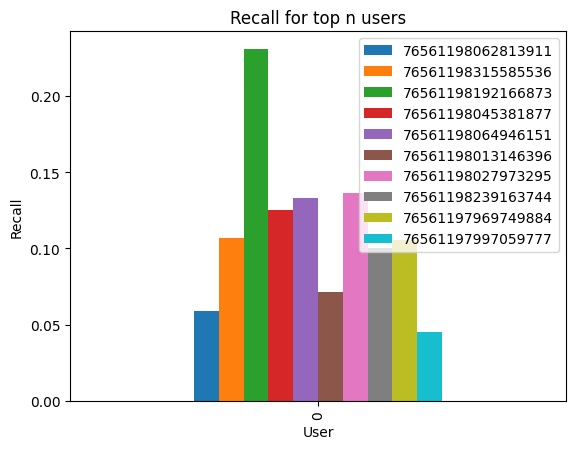

In [51]:
import matplotlib.pyplot as plt

stat.plot(kind='bar', x=None)  # Assumes the column names are used as x-axis labels
plt.title('Recall for top n users')
plt.xlabel('User')
plt.ylabel('Recall')
plt.show()

In [66]:
data = [0.1, 0.1, 0.2, 0.3, 0.3, 0.4]

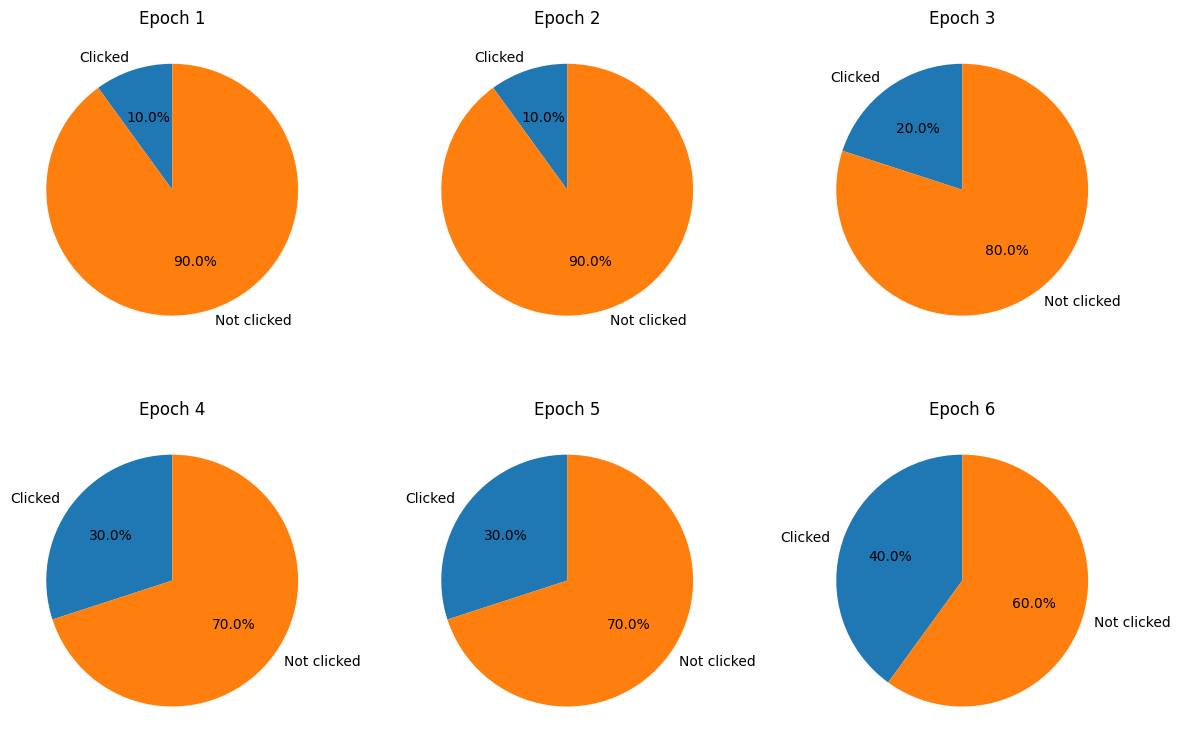

In [67]:
def plot_pie(data):
    _, axs = plt.subplots(2, 3, figsize=(12, 8))

    axs = axs.flatten()

    for i, value in enumerate(data):
        axs[i].pie([value, 1 - value], labels=['Clicked', 'Not clicked'], autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'Epoch {i + 1}')

    plt.tight_layout()
    plt.show()

plot_pie(data)

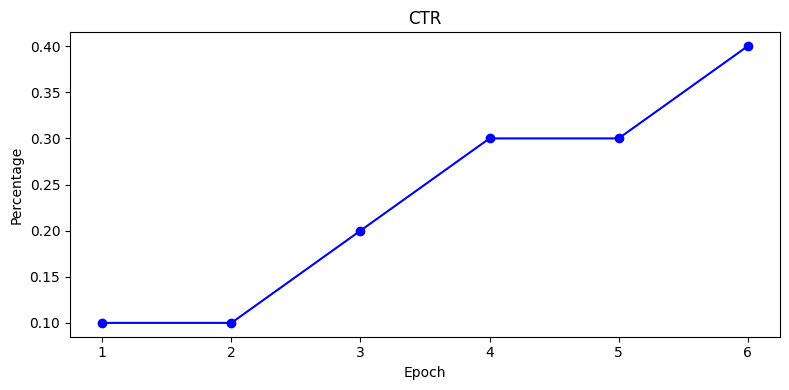

In [68]:
def plot_line(data):

    x_values = np.arange(1, 7)
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, data, marker='o', linestyle='-', color='b')
    plt.title('CTR')
    plt.xlabel('Epoch')
    plt.ylabel('Percentage')

    plt.tight_layout()
    plt.show()

plot_line(data)